In [14]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import h5py, csv

In [15]:
# Model Definition
P3 = 128
# Modality Specific Module
class ModalitySpecificModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)  
    # Text MSM Layers
    self.bigru_text = keras.layers.Bidirectional(keras.layers.GRU(256))
    self.msl_1_text = keras.layers.Dense(128, activation='relu')
    self.msl_2_text = keras.layers.Dense(P3, activation='relu')
    # Audio MSM Layers
    self.bigru_audio = keras.layers.Bidirectional(keras.layers.GRU(256))
    self.msl_1_audio = keras.layers.Dense(128, activation='relu')
    self.msl_2_audio = keras.layers.Dense(P3, activation='relu')
    # Visual MSM Layers
    self.bigru_visual = keras.layers.Bidirectional(keras.layers.GRU(256))
    self.msl_1_visual = keras.layers.Dense(128, activation='relu')
    self.msl_2_visual = keras.layers.Dense(P3, activation='relu')

  def __call__(self, text_input, audio_input, visual_input):
    # Text MSM
    bigru_text_output = self.bigru_text(text_input)
    msl_l1_text = self.msl_1_text(bigru_text_output)
    text_msm_output = self.msl_2_text(msl_l1_text)
    # Audio MSM
    bigru_audio_output = self.bigru_audio(audio_input)
    msl_l1_audio = self.msl_1_audio(bigru_audio_output)
    audio_msm_output = self.msl_2_audio(msl_l1_audio)
    # Visual MSM
    bigru_visual_output = self.bigru_visual(visual_input)
    msl_l1_visual = self.msl_1_visual(bigru_visual_output)
    visual_msm_output = self.msl_2_visual(msl_l1_visual)

    return text_msm_output, audio_msm_output, visual_msm_output


# Dense Multimodal Fusion Module
class DenseMultimodalFusionModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.residual_features = []

  def df_wrapper(self, f1, f2, f3, n):
    for i in range(n):
      f1, f2, f3 = self.df_layer(f1, f2, f3)
    r = keras.layers.Add()([f1, f2, f3])
    self.residual_features.append(r)
    return self.residual_features

  # df layer
  def df_layer(self, f1, f2, f3):
    r = keras.layers.Add()([f1, f2, f3])
    self.residual_features.append(r)
    # concatenation before feeding to df block
    df_input1 = keras.layers.Concatenate()([f1, f3])
    df_input2 = keras.layers.Concatenate()([f1, f2])
    df_input3 = keras.layers.Concatenate()([f2, f3])
    # df block
    df_output1 = keras.layers.Dense(P3, activation='relu')(df_input1)
    df_output2 = keras.layers.Dense(P3, activation='relu')(df_input2)
    df_output3 = keras.layers.Dense(P3, activation='relu')(df_input3)

    return df_output1, df_output2, df_output3

  def __call__(self, f1_0, f2_0, f3_0):
    DF_LAYER_COUNT = 16
    residual = self.df_wrapper(f1_0, f2_0, f3_0, DF_LAYER_COUNT)
    return residual


# Multimodal Residual Module
class MultimodalResidualModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, residual_features):
    final_residual_feature = keras.layers.Add()(residual_features)
    return final_residual_feature


# Sentiment Classification Module
class SentimentClassificationModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer_1 = keras.layers.Dense(128, activation='relu')
    self.layer_2 = keras.layers.Dense(64, activation='relu')
    self.layer_3 = keras.layers.Dense(32, activation='relu')
    self.layer_4 = keras.layers.Dense(16, activation='relu')
    num_classes = 5
    self.classification_layer = keras.layers.Dense(num_classes, activation='softmax')

  def __call__(self, residual_feature):
    output_l1 = self.layer_1(residual_feature)
    output_l2 = self.layer_2(output_l1)
    output_l3 = self.layer_3(output_l2)
    output_l4 = self.layer_4(output_l3)
    sentiment = self.classification_layer(output_l4)
    return sentiment

# deep dense fusion network with multimodal residual (DFMR)
class DFMR(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.text_input = keras.Input(shape=(1, 768))
    self.audio_input = keras.Input(shape=(1, 768))
    self.visual_input = keras.Input(shape=(5226, 512))

    # Major Modules of DFMR
    self.msm = ModalitySpecificModule()
    self.dmfm = DenseMultimodalFusionModule()
    self.mrm = MultimodalResidualModule()
    self.scm = SentimentClassificationModule()

  def __call__(self):
    # major module structure overview
    text_msm_output, audio_msm_output, visual_msm_output = self.msm(self.text_input, self.audio_input, self.visual_input)
    residual_features = self.dmfm(text_msm_output, audio_msm_output, visual_msm_output)
    final_residual_feature = self.mrm(residual_features)
    output = self.scm(final_residual_feature)    
    # model definition
    model = keras.Model(inputs=[self.text_input, self.audio_input, self.visual_input], outputs=output)
    return model


dfmr_model = DFMR()
model = dfmr_model()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1, 768)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 1, 768)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 5226, 512) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 512)       │  1,575,936 │ input_layer_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 512)       │  1,575,936 │ input_layer_4[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 512)       │  1,182,720 │ input_layer_5[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, 128)       │     65,664 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 128)       │     65,664 │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 128)       │     65,664 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 128)       │     16,512 │ dense_59[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 128)       │     16,512 │ dense_61[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 128)       │     16,512 │ dense_63[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_48      │ (None, 256)       │          0 │ dense_60[0][0],   │
│ (Concatenate)       │                   │            │ dense_64[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_49      │ (None, 256)       │          0 │ dense_60[0][0],   │
│ (Concatenate)       │                   │            │ dense_62[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_50      │ (None, 256)       │          0 │ dense_62[0][0],   │
│ (Concatenate)       │                   │            │ dense_64[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_70 (Dense)    │ (None, 128)       │     32,896 │ concatenate_48[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_71 (Dense)    │ (None, 128)       │     32,896 │ concatenate_49[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_72 (Dense)    │ (None, 128)       │     32,896 │ concatenate_50[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_51      │ (None, 256)       │          0 │ dense_70[0][0],   │
│ (Concatenate)       │                   │            │ dense_72[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_52      │ (None, 256)       │          0 │ dense_70[0][0], 

 Total params: 6,187,589 (23.60 MB)

 Trainable params: 6,187,589 (23.60 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(
  optimizer='adam',
  loss=keras.losses.MeanAbsoluteError(),
  metrics=[
    keras.metrics.Accuracy()
  ]
)

In [17]:
audio_embeddings = {}
transcript_embeddings = {}
video_embeddings = {}

with h5py.File('../../datasets/Dravidian Dataset/malayalam_data/embeddings/audio_embeddings.h5', 'r') as f:
  a_ids = list(f.keys())
  a_max_shape = f[a_ids[0]].shape
  for i in a_ids:
    audio_embeddings[i] = f[i][:]
    shape = f[i].shape
    if a_max_shape < shape:
      a_max_shape = shape
  
  for key,value in audio_embeddings.items():
    padded_value = np.pad(value, ((0, a_max_shape[0] - value.shape[0])), mode='constant')
    reshaped_value = padded_value.reshape((1, padded_value.shape[0]))
    audio_embeddings[key] = reshaped_value
    # print(audio_embeddings[key].shape)

with h5py.File('../../datasets/Dravidian Dataset/malayalam_data/embeddings/transcript_embeddings.h5', 'r') as f:
  t_ids = list(f.keys())
  t_max_shape = f[t_ids[0]].shape
  for i in t_ids:
    transcript_embeddings[i] = f[i][:]
    shape = f[i].shape
    if t_max_shape < shape:
      t_max_shape = shape
      
  for key,value in transcript_embeddings.items():
    padded_value = np.pad(value, ((0, t_max_shape[0] - value.shape[0])), mode='constant')
    transcript_embeddings[key] = padded_value
    # print(transcript_embeddings[key].shape)

with h5py.File('../../datasets/Dravidian Dataset/malayalam_data/embeddings/video_embeddings.h5', 'r') as f:
  v_ids = list(f.keys())
  v_max_shape = f[v_ids[0]].shape
  for i in v_ids:
    video_embeddings[i] = f[i][:]
    shape = f[i].shape
    if v_max_shape < shape:
      v_max_shape = shape

  for key,value in video_embeddings.items():
    padded_value = np.pad(value, ((0, v_max_shape[0] - value.shape[0]), (0, v_max_shape[1] - value.shape[1])), mode='constant')
    video_embeddings[key] = padded_value
    # print(video_embeddings[key].shape)

a_ids = v_ids
t_ids = v_ids

In [18]:
video_embeddings_list = []
for k in v_ids:
  video_embeddings_list.append(video_embeddings[k])
video_embeddings_array = np.array(video_embeddings_list)
v_eager_tensor = tf.convert_to_tensor(video_embeddings_array)
print(v_eager_tensor.shape)

audio_embeddings_list = []
for k in a_ids:
  audio_embeddings_list.append(audio_embeddings[k])
audio_embeddings_array = np.array(audio_embeddings_list)
a_eager_tensor = tf.convert_to_tensor(audio_embeddings_array)
print(a_eager_tensor.shape)

transcript_embeddings_list = []
for k in t_ids:
  transcript_embeddings_list.append(transcript_embeddings[k])
transcript_embeddings_array = np.array(transcript_embeddings_list)
t_eager_tensor = tf.convert_to_tensor(transcript_embeddings_array)
print(t_eager_tensor.shape)

(69, 5226, 512)
(69, 1, 768)
(69, 1, 768)


In [19]:
def convertLabels(label):
  rep = {
    -2 : [1., 0., 0., 0., 0.],
    -1 : [0., 1., 0., 0., 0.],
    0 : [0., 0., 1., 0., 0.],
    1 : [0., 0., 0., 1., 0.],
    2 : [0., 0., 0., 0., 1.]
  }
  return tf.convert_to_tensor(rep[label])

text_input = t_eager_tensor
audio_input = a_eager_tensor
visual_input = v_eager_tensor

labels_dict = {}
labels_list = []
labels_path = '../../datasets/Dravidian Dataset/malayalam_data/labels/labels.csv'
with open(labels_path, newline='') as csvfile:
  reader = csv.DictReader(csvfile)
  # removed MAL_MSA_18 since it has no video file
  for row,k in zip(reader, t_ids):
    labels_dict[k] = convertLabels(int(row['label']))
    labels_list.append(labels_dict[k])
labels_array = np.array(labels_list)
labels_eager_tensor = tf.convert_to_tensor(labels_array)
print(labels_eager_tensor.shape)

label_input = labels_eager_tensor

(69, 5)


In [1]:
text_train = text_input[0:52]
audio_train = audio_input[0:52]
visual_train = visual_input[0:52]
label_train = label_input[0:52]

text_validation = text_input[52:59]
audio_validation = audio_input[52:59]
visual_validation = visual_input[52:59]
label_validation = label_input[52:59]

text_test = text_input[59:]
audio_test = audio_input[59:]
visual_test = visual_input[59:]
label_test = label_input[59:]

train_dataset = [text_train, audio_train, visual_train]

validation_data = ([text_validation, audio_validation, visual_validation], label_validation)

test_dataset = [text_test, audio_test, visual_test]

NameError: name 'text_input' is not defined

In [22]:
epochs = 100
history = model.fit(train_dataset, label_train, validation_data=validation_data, epochs=epochs)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 9s/step - accuracy: 0.0000e+00 - loss: 0.3167 - val_accuracy: 0.0000e+00 - val_loss: 0.3169
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.0000e+00 - loss: 0.2654  

2024-04-02 15:59:33.714339: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96381108 bytes after encountering the first element of size 96381108 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - accuracy: 0.0000e+00 - loss: 0.2577 - val_accuracy: 0.0000e+00 - val_loss: 0.2667
Epoch 3/50


2024-04-02 15:59:35.177154: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - accuracy: 0.0281 - loss: 0.1665 - val_accuracy: 0.0667 - val_loss: 0.2667
Epoch 4/50


2024-04-02 16:00:02.589482: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1850 - loss: 0.1793  

2024-04-02 16:00:28.933920: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96381108 bytes after encountering the first element of size 96381108 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - accuracy: 0.1931 - loss: 0.1893 - val_accuracy: 0.7111 - val_loss: 0.2667
Epoch 5/50


2024-04-02 16:00:43.534706: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8153 - loss: 0.1781 

2024-04-02 16:01:06.830729: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96381108 bytes after encountering the first element of size 96381108 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - accuracy: 0.8144 - loss: 0.1827 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 6/50


2024-04-02 16:01:08.509083: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8234 - loss: 0.1822 

2024-04-02 16:01:34.970701: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96381108 bytes after encountering the first element of size 96381108 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - accuracy: 0.8226 - loss: 0.1858 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 7/50


2024-04-02 16:01:49.465245: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8047 - loss: 0.1785 

2024-04-02 16:02:13.430379: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96381108 bytes after encountering the first element of size 96381108 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.8086 - loss: 0.1661 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 8/50


2024-04-02 16:02:14.974146: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7984 - loss: 0.1922  

2024-04-02 16:02:43.005750: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96381108 bytes after encountering the first element of size 96381108 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 9s/step - accuracy: 0.8039 - loss: 0.1821 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 9/50


2024-04-02 16:02:44.562460: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 8s/step - accuracy: 0.8133 - loss: 0.1727 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 10/50


2024-04-02 16:03:11.984396: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8273 - loss: 0.1699 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 11/50


2024-04-02 16:03:37.745124: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8195 - loss: 0.2115 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 12/50


2024-04-02 16:04:03.839332: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8070 - loss: 0.1790 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 13/50


2024-04-02 16:04:44.782529: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.8180 - loss: 0.1793 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 14/50


2024-04-02 16:05:08.284112: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8164 - loss: 0.1696 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 15/50


2024-04-02 16:05:34.389708: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8117 - loss: 0.1855 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 16/50


2024-04-02 16:06:00.357024: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.8226 - loss: 0.1633 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 17/50


2024-04-02 16:06:25.816947: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8305 - loss: 0.1668 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 18/50


2024-04-02 16:06:51.519165: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8195 - loss: 0.1665 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 19/50


2024-04-02 16:07:17.344048: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8211 - loss: 0.1986 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 20/50


2024-04-02 16:07:43.208051: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8289 - loss: 0.1796 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 21/50


2024-04-02 16:08:08.970005: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8258 - loss: 0.1827 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 22/50


2024-04-02 16:08:34.622222: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8117 - loss: 0.1855 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 23/50


2024-04-02 16:09:00.633006: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8226 - loss: 0.1633 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 24/50


2024-04-02 16:09:26.189787: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8226 - loss: 0.1858 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 25/50


2024-04-02 16:09:51.978746: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - accuracy: 0.8305 - loss: 0.1668 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 26/50


2024-04-02 16:10:19.678277: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 9s/step - accuracy: 0.8164 - loss: 0.2146 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 27/50


2024-04-02 16:10:49.030622: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - accuracy: 0.8211 - loss: 0.1761 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 28/50


2024-04-02 16:11:17.033659: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8258 - loss: 0.1602 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 29/50


2024-04-02 16:11:42.970861: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8195 - loss: 0.1890 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 30/50


2024-04-02 16:12:09.225009: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8258 - loss: 0.1827 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 31/50


2024-04-02 16:12:35.625041: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8180 - loss: 0.1793 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 32/50


2024-04-02 16:13:01.477878: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8273 - loss: 0.1924 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 33/50


2024-04-02 16:13:27.285697: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8086 - loss: 0.1886 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 34/50


2024-04-02 16:13:53.457066: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8109 - loss: 0.1947 

2024-04-02 16:14:18.084060: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96381108 bytes after encountering the first element of size 96381108 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8133 - loss: 0.1952 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 35/50


2024-04-02 16:14:19.512862: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8211 - loss: 0.1761 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 36/50


2024-04-02 16:14:45.637612: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8258 - loss: 0.2052 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 37/50


2024-04-02 16:15:11.511681: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8289 - loss: 0.1796 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 38/50


2024-04-02 16:15:37.283379: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8130 - loss: 0.1851

2024-04-02 16:16:01.659843: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96381108 bytes after encountering the first element of size 96381108 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8148 - loss: 0.1824 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 39/50


2024-04-02 16:16:03.126582: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8273 - loss: 0.1699 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 40/50


2024-04-02 16:16:28.860546: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8148 - loss: 0.1599 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 41/50


2024-04-02 16:16:54.641690: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8273 - loss: 0.1699 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 42/50


2024-04-02 16:17:20.680579: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8242 - loss: 0.1955 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 43/50


2024-04-02 16:17:46.443044: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8242 - loss: 0.1730 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 44/50


2024-04-02 16:18:12.357138: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.7961 - loss: 0.1786 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 45/50


2024-04-02 16:18:38.407998: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8195 - loss: 0.1890 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 46/50


2024-04-02 16:19:04.361118: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8086 - loss: 0.1886 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 47/50


2024-04-02 16:19:30.226385: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - accuracy: 0.8133 - loss: 0.1952 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 48/50


2024-04-02 16:19:56.936891: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8101 - loss: 0.1983 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 49/50


2024-04-02 16:20:22.784251: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8148 - loss: 0.1824 - val_accuracy: 0.7333 - val_loss: 0.2667
Epoch 50/50


2024-04-02 16:20:48.503899: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.8195 - loss: 0.1665 - val_accuracy: 0.7333 - val_loss: 0.2667


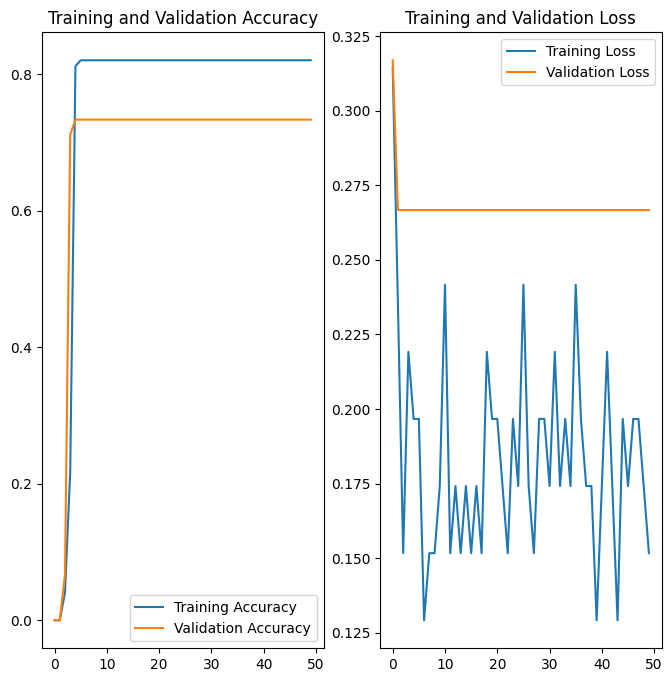

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(4, 4))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize=(4, 4))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
print("Evaluate on test data")
results = model.evaluate(test_dataset, label_test)
print("test loss, test acc:", results)

Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step - accuracy: 0.6000 - loss: 0.4000
test loss, test acc: [0.4000000059604645, 0.6000000238418579]
